# Matriz: extracción de métricas desde logs (*.out)

Este cuaderno escanea todos los archivos que terminen en `.out` dentro de la carpeta `logs` y extrae las siguientes métricas para construir una tabla (DataFrame):

- `Procesos MPI`
- `Tamaño de Matriz`
- `Tiempo Total (Wall-Clock)`
- `Tiempo Total (Kernel Paralelo)`
- `Tiempo de Comunicación`
- `Tiempo de Cómputo (max)`

Luego muestra la tabla y opcionalmente la guarda como CSV en la misma carpeta `logs`.

---

Instrucciones:
- Ejecuta las celdas en orden. La primera detecta automáticamente la carpeta `logs`.
- Si deseas desactivar el guardado a CSV, cambia `save_csv = True` a `False` en la última celda.


In [1]:
from pathlib import Path
import re
import pandas as pd

# --- Localización de la carpeta de logs ---
# Este notebook vive en 10_matrix_multiplication_tarea/.
# Intentamos primero './logs', y como respaldo '../10_matrix_multiplication_tarea/logs' por si el CWD es el raíz del repo.

candidates = [
##    Path.cwd() / 'logs',
    Path.cwd().parent / '10_matrix_multiplication_tarea' / 'logs'
]
logs_dir = next((p for p in candidates if p.exists() and p.is_dir()), None)
if logs_dir is None:
    raise FileNotFoundError(
        'No se encontró la carpeta de logs. Probados: ' + ', '.join(str(p) for p in candidates)
    )

print(f'Usando carpeta de logs: {logs_dir}')
out_files = sorted(logs_dir.glob('*.out'))
print(f'Archivos .out encontrados: {len(out_files)}')
if not out_files:
    raise FileNotFoundError('No se encontraron archivos .out en la carpeta de logs.')

# --- Patrones regex (sensibles a acentos y espacios) ---
# Cada patrón captura un grupo: el valor numérico (o el tamaño AxB).
patterns = {
    'Procesos MPI': re.compile(r'Procesos\s+MPI:\s*(\d+)', re.IGNORECASE),
    'Tamaño de Matriz': re.compile(r'Tamaño\s+de\s+Matriz:\s*([0-9]+x[0-9]+)', re.IGNORECASE),
    'Tiempo Total (Wall-Clock)': re.compile(r'Tiempo\s+Total\s*\(Wall-Clock\):\s*([0-9.]+)\s*s', re.IGNORECASE),
    'Tiempo Total (Kernel Paralelo)': re.compile(r'Tiempo\s+Total\s*\(Kernel\s+Paralelo\):\s*([0-9.]+)\s*s', re.IGNORECASE),
    'Tiempo de Comunicación': re.compile(r'Tiempo\s+de\s+Comunicación:\s*([0-9.]+)\s*s', re.IGNORECASE),
    'Tiempo de Cómputo (max)': re.compile(r'Tiempo\s+de\s+Cómputo\s*\(max\):\s*([0-9.]+)\s*s', re.IGNORECASE),
}

def parse_metrics(text: str) -> dict:
    row = {}
    for key, pat in patterns.items():
        m = pat.search(text)
        if m:
            row[key] = m.group(1)
        else:
            row[key] = None
    return row

rows = []
for f in out_files:
    try:
        text = f.read_text(encoding='utf-8', errors='replace')
    except Exception as e:
        print(f'Error leyendo {f.name}: {e}')
        continue
    data = parse_metrics(text)
    data['archivo'] = f.name
    # Conversiones de tipo
    # Procesos MPI -> int
    if data.get('Procesos MPI') is not None:
        try:
            data['Procesos MPI'] = int(data['Procesos MPI'])
        except ValueError:
            pass
    # Tiempos -> float
    for col in [
        'Tiempo Total (Wall-Clock)',
        'Tiempo Total (Kernel Paralelo)',
        'Tiempo de Comunicación',
        'Tiempo de Cómputo (max)',
    ]:
        if data.get(col) is not None:
            try:
                data[col] = float(data[col])
            except ValueError:
                pass
    rows.append(data)

# DataFrame ordenado
cols = [
    'archivo',
    'Procesos MPI',
    'Tamaño de Matriz',
    'Tiempo Total (Wall-Clock)',
    'Tiempo Total (Kernel Paralelo)',
    'Tiempo de Comunicación',
    'Tiempo de Cómputo (max)',
]
df = pd.DataFrame(rows)[cols]
df = df.sort_values(by=['Tamaño de Matriz', 'Procesos MPI', 'archivo'], na_position='last').reset_index(drop=True)
df


Usando carpeta de logs: /home/s.lopezmedina/Maestria/4_hpc/codigo/10_matrix_multiplication_tarea/logs
Archivos .out encontrados: 48


,archivo,Procesos MPI,Tamaño de Matriz,Tiempo Total (Wall-Clock),Tiempo Total (Kernel Paralelo),Tiempo de Comunicación,Tiempo de Cómputo (max)
0,matmul_19865_0.out,1.0,1024x1024,0.137789,0.018840,0.004034,0.014803
1,matmul_19865_1.out,2.0,1024x1024,0.159944,0.016970,0.008039,0.009570
2,matmul_19865_2.out,4.0,1024x1024,0.214494,0.016742,0.011007,0.006134
3,matmul_19865_3.out,8.0,1024x1024,0.301273,0.029574,0.024007,0.009111
4,matmul_19865_4.out,16.0,1024x1024,0.536116,0.030500,0.024705,0.008572
5,matmul_19865_5.out,32.0,1024x1024,1.016682,0.042807,0.035218,0.011437
6,matmul_19865_24.out,1.0,16384x16384,49.973762,47.073343,0.732545,46.340786
7,matmul_19865_25.out,2.0,16384x16384,30.000291,26.935270,0.938124,26.284902
8,matmul_19865_26.out,4.0,16384x16384,21.331672,18.126507,1.492225,16.634266
9,matmul_19865_27.out,8.0,16384x16384,15.317410,12.033281,2.845009,9.414624


In [3]:
# Guardado opcional a CSV
save_csv = True  # Cambia a False si no quieres escribir el CSV
csv_path = logs_dir.parent / 'metrics_summary.csv'
if save_csv:
    df.to_csv(csv_path, index=False)
    print(f'Tabla guardada en: {csv_path}')

df.head(len(df))  # mostrar todo en notebooks pequeños


Tabla guardada en: /home/s.lopezmedina/Maestria/4_hpc/codigo/10_matrix_multiplication_tarea/metrics_summary.csv


,archivo,Procesos MPI,Tamaño de Matriz,Tiempo Total (Wall-Clock),Tiempo Total (Kernel Paralelo),Tiempo de Comunicación,Tiempo de Cómputo (max)
0,matmul_19865_0.out,1.0,1024x1024,0.137789,0.018840,0.004034,0.014803
1,matmul_19865_1.out,2.0,1024x1024,0.159944,0.016970,0.008039,0.009570
2,matmul_19865_2.out,4.0,1024x1024,0.214494,0.016742,0.011007,0.006134
3,matmul_19865_3.out,8.0,1024x1024,0.301273,0.029574,0.024007,0.009111
4,matmul_19865_4.out,16.0,1024x1024,0.536116,0.030500,0.024705,0.008572
5,matmul_19865_5.out,32.0,1024x1024,1.016682,0.042807,0.035218,0.011437
6,matmul_19865_24.out,1.0,16384x16384,49.973762,47.073343,0.732545,46.340786
7,matmul_19865_25.out,2.0,16384x16384,30.000291,26.935270,0.938124,26.284902
8,matmul_19865_26.out,4.0,16384x16384,21.331672,18.126507,1.492225,16.634266
9,matmul_19865_27.out,8.0,16384x16384,15.317410,12.033281,2.845009,9.414624


In [15]:
import polars as pl
df_full_measures = pl.from_pandas(df).drop_nulls().filter((pl.col('Tamaño de Matriz')=='32768x32768').not_()).with_columns(
    pl.col('Tiempo Total (Wall-Clock)').filter(pl.col('Procesos MPI') == 1).first().over('Tamaño de Matriz').alias(
        'numerador_speedup')).with_columns(
    speedup=pl.col('numerador_speedup') / pl.col('Tiempo Total (Wall-Clock)')).with_columns(
    efficiency=pl.col('speedup') / pl.col('Procesos MPI'),speedup_pct_change=pl.col('speedup').pct_change().over('Tamaño de Matriz',order_by='Procesos MPI'), mat_size= pl.col('Tamaño de Matriz').str.split("x").list.get(0).cast(pl.Int32)).sort(by=['mat_size','Procesos MPI'])
df_full_measures


archivo,Procesos MPI,Tamaño de Matriz,Tiempo Total (Wall-Clock),Tiempo Total (Kernel Paralelo),Tiempo de Comunicación,Tiempo de Cómputo (max),numerador_speedup,speedup,efficiency,speedup_pct_change,mat_size
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,i32
"""matmul_19865_0.out""",1.0,"""1024x1024""",0.137789,0.01884,0.004034,0.014803,0.137789,1.0,1.0,null,1024
"""matmul_19865_1.out""",2.0,"""1024x1024""",0.159944,0.01697,0.008039,0.00957,0.137789,0.861483,0.430741,-0.138517,1024
"""matmul_19865_2.out""",4.0,"""1024x1024""",0.214494,0.016742,0.011007,0.006134,0.137789,0.642391,0.160598,-0.254319,1024
"""matmul_19865_3.out""",8.0,"""1024x1024""",0.301273,0.029574,0.024007,0.009111,0.137789,0.457356,0.057169,-0.288041,1024
"""matmul_19865_4.out""",16.0,"""1024x1024""",0.536116,0.0305,0.024705,0.008572,0.137789,0.257013,0.016063,-0.438045,1024
…,…,…,…,…,…,…,…,…,…,…,…
"""matmul_19865_25.out""",2.0,"""16384x16384""",30.000291,26.93527,0.938124,26.284902,49.973762,1.665776,0.832888,0.665776,16384
"""matmul_19865_26.out""",4.0,"""16384x16384""",21.331672,18.126507,1.492225,16.634266,49.973762,2.342703,0.585676,0.406373,16384
"""matmul_19865_27.out""",8.0,"""16384x16384""",15.31741,12.033281,2.845009,9.414624,49.973762,3.262546,0.407818,0.392642,16384


In [20]:
df_full_measures.write_csv(logs_dir.parent / 'metrics_summary.csv', include_header=True)

# Gráficas: Tiempo, Speedup y Eficiencia

A continuación se generan tres gráficos usando el DataFrame `df_full_measures` (Polars):
- Tiempo total (Wall-Clock) vs Procesos MPI (log-log), una línea por tamaño de matriz.
- Speedup vs Procesos MPI (log-log), una línea por tamaño de matriz, incluyendo una línea ideal.
- Eficiencia vs Procesos MPI (semilog-x), una línea por tamaño de matriz.


/tmp/ipykernel_13811/1671731149.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(sizes))


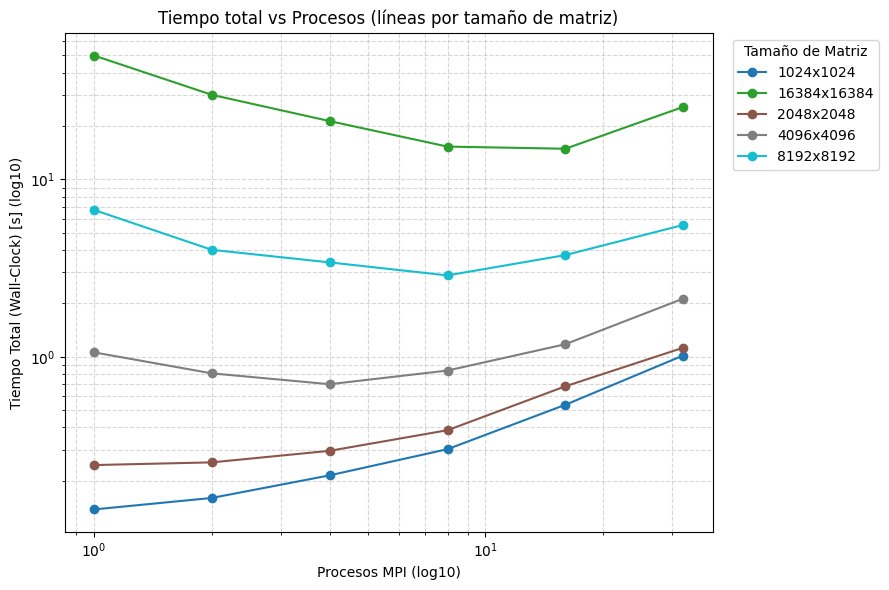

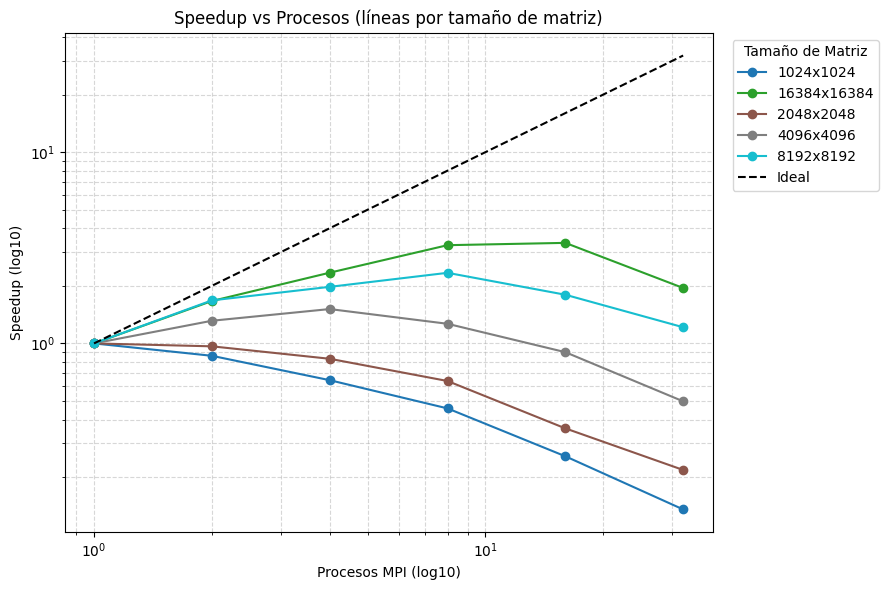

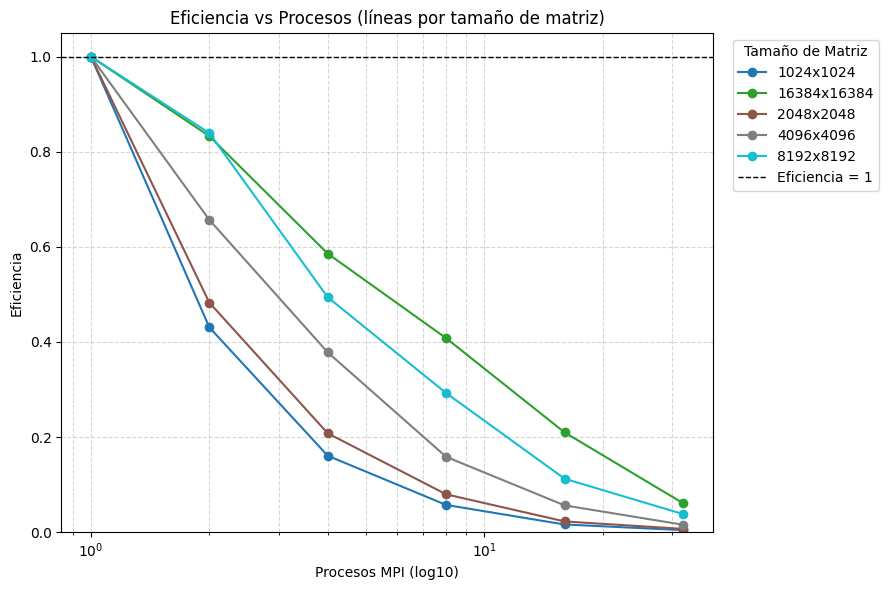

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm

# Filtrado de filas válidas y conversión a pandas para graficar
cols_needed = ['Procesos MPI','Tamaño de Matriz','Tiempo Total (Wall-Clock)','speedup','efficiency']
df_plot = (
    df_full_measures
    .select(cols_needed)
    .drop_nulls()
    .filter((pl.col('Procesos MPI') > 0) &
            (pl.col('Tiempo Total (Wall-Clock)') > 0) &
            (pl.col('speedup') > 0) &
            (pl.col('efficiency') > 0))
    .sort(['Tamaño de Matriz','Procesos MPI'])
)
pdf = df_plot.to_pandas()

sizes = sorted(pdf['Tamaño de Matriz'].unique())
cmap = cm.get_cmap('tab10', len(sizes))
color_for = {size: cmap(i) for i, size in enumerate(sizes)}

# --- 1) Tiempo total (Wall-Clock) vs Procesos MPI (log-log) ---
plt.figure(figsize=(9,6))
for size in sizes:
    sub = pdf[pdf['Tamaño de Matriz'] == size].sort_values('Procesos MPI')
    plt.plot(sub['Procesos MPI'], sub['Tiempo Total (Wall-Clock)'], marker='o', label=size, color=color_for[size])
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.xlabel('Procesos MPI (log10)')
plt.ylabel('Tiempo Total (Wall-Clock) [s] (log10)')
plt.title('Tiempo total vs Procesos (líneas por tamaño de matriz)')
plt.legend(title='Tamaño de Matriz', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 2) Speedup vs Procesos MPI (log-log), con línea ideal ---
plt.figure(figsize=(9,6))
for size in sizes:
    sub = pdf[pdf['Tamaño de Matriz'] == size].sort_values('Procesos MPI')
    plt.plot(sub['Procesos MPI'], sub['speedup'], marker='o', label=size, color=color_for[size])
plt.xscale('log')
plt.yscale('log')
# Línea ideal: speedup = P
xs = np.unique(pdf['Procesos MPI'].values)
xs = np.sort(xs)
if xs.size > 0:
    plt.plot(xs, xs, 'k--', label='Ideal')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.xlabel('Procesos MPI (log10)')
plt.ylabel('Speedup (log10)')
plt.title('Speedup vs Procesos (líneas por tamaño de matriz)')
plt.legend(title='Tamaño de Matriz', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- 3) Eficiencia vs Procesos MPI (semilog-x) ---
plt.figure(figsize=(9,6))
for size in sizes:
    sub = pdf[pdf['Tamaño de Matriz'] == size].sort_values('Procesos MPI')
    plt.plot(sub['Procesos MPI'], sub['efficiency'], marker='o', label=size, color=color_for[size])
plt.xscale('log')  # semilog-x
plt.ylim(0, 1.05)
plt.axhline(1.0, color='k', linestyle='--', linewidth=1, label='Eficiencia = 1')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.xlabel('Procesos MPI (log10)')
plt.ylabel('Eficiencia')
plt.title('Eficiencia vs Procesos (líneas por tamaño de matriz)')
plt.legend(title='Tamaño de Matriz', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Guardado opcional de figuras
save_figs = False  # cambia a True para guardar las imágenes
figs_dir = logs_dir / 'figs'
if save_figs:
    figs_dir.mkdir(parents=True, exist_ok=True)

    # 1) Tiempo vs Procesos
    plt.figure(figsize=(9,6))
    for size in sizes:
        sub = pdf[pdf['Tamaño de Matriz'] == size].sort_values('Procesos MPI')
        plt.plot(sub['Procesos MPI'], sub['Tiempo Total (Wall-Clock)'], marker='o', label=size, color=color_for[size])
    plt.xscale('log'); plt.yscale('log'); plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.xlabel('Procesos MPI (log10)'); plt.ylabel('Tiempo Total (Wall-Clock) [s] (log10)')
    plt.title('Tiempo total vs Procesos'); plt.legend(title='Tamaño de Matriz'); plt.tight_layout()
    plt.savefig(figs_dir / 'tiempo_vs_procesos_loglog.png', dpi=150)

    # 2) Speedup vs Procesos
    plt.figure(figsize=(9,6))
    for size in sizes:
        sub = pdf[pdf['Tamaño de Matriz'] == size].sort_values('Procesos MPI')
        plt.plot(sub['Procesos MPI'], sub['speedup'], marker='o', label=size, color=color_for[size])
    plt.xscale('log'); plt.yscale('log'); plt.grid(True, which='both', ls='--', alpha=0.5)
    xs = np.unique(pdf['Procesos MPI'].values); xs = np.sort(xs)
    if xs.size > 0:
        plt.plot(xs, xs, 'k--', label='Ideal')
    plt.xlabel('Procesos MPI (log10)'); plt.ylabel('Speedup (log10)'); plt.title('Speedup vs Procesos')
    plt.legend(title='Tamaño de Matriz'); plt.tight_layout()
    plt.savefig(figs_dir / 'speedup_vs_procesos_loglog.png', dpi=150)

    # 3) Eficiencia vs Procesos (semilog-x)
    plt.figure(figsize=(9,6))
    for size in sizes:
        sub = pdf[pdf['Tamaño de Matriz'] == size].sort_values('Procesos MPI')
        plt.plot(sub['Procesos MPI'], sub['efficiency'], marker='o', label=size, color=color_for[size])
    plt.xscale('log'); plt.ylim(0, 1.05); plt.axhline(1.0, color='k', linestyle='--', linewidth=1, label='Eficiencia = 1')
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.xlabel('Procesos MPI (log10)'); plt.ylabel('Eficiencia'); plt.title('Eficiencia vs Procesos')
    plt.legend(title='Tamaño de Matriz'); plt.tight_layout()
    plt.savefig(figs_dir / 'eficiencia_vs_procesos_semilogx.png', dpi=150)
